In [1]:
# upgrade scipy to be able to use qmc
# after that automatically restarts the cell
#####import os
#####! pip install scipy --upgrade
######os.kill(os.getpid(), 9)

In [2]:
import numpy as np
import time
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import qmc

In [3]:
tf.keras.backend.set_floatx("float64")

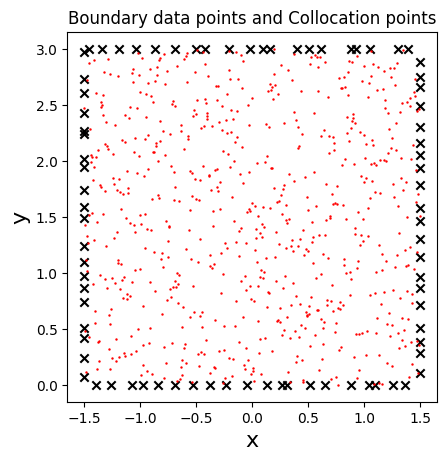

In [4]:
# Arcade structure with different BC on the 4 boundaries ....
# We solve ->  Delta u + lam**2 * u = 0
# where lam is a constant ..............................
# Note that lam**2 * u can also be replaced by a non linear function of u like exp(-u) for example
# but in the ltter case, the exact solution is a prori uknown
# ...............................................................................................

### data generation on the boundaries ..... x between -lim1 and lim1
# and y between 0 and lim2 ...................................
n_bc = 4
n_data_per_bc = 20

#
engine = qmc.LatinHypercube(d=1)
data = np.zeros([n_bc ,n_data_per_bc , 3])

#
lim1 =3./2
lim2 =3

# ......................................................
# Arcade : conditions at boundaries ....................
#........................................................

for i, j in zip(range(n_bc), [0., 1., 0, 1.]):
    points = (engine.random(n=n_data_per_bc)[:, 0] - 0.) * 1
    #points = np.linspace(0, +1, n_data_per_bc)
    
    if i < 2:
        data[i, :, 0] = j + 0.
        data[i, :, 1] = points - 0.
    else:
        data[i, :, 0] = points + 0.
        data[i, :, 1] = j -0.

data[:, :, 0] = 2*lim1 * data[:, :, 0] - lim1
data[:, :, 1] = data[:, :, 1] * lim2
                
# We define the values to select the solution ...
nn3=3    # mode 3 coefficient
nn1=1   # mode 1 coefficient
nn2 = 2 # mode 2 ....

lam=0.8   # for the equation .... (see paper)


# Choose the coefficients to select the problem (see paper) ........
a3= -0.5
a2 = 0
a1 = 1
kk3= np.sqrt(nn3**2*np.pi**2/lim2/lim2 - lam**2)
kk1 = np.sqrt(nn1**2*np.pi**2/lim2/lim2 - lam**2)
kk2 = np.sqrt(nn2**2*np.pi**2/lim2/lim2 - lam**2)

# Exact solution - used for BC (Dirichlet type here) and to evaluate the error at the end !
def tru(x, y):      
    tru =a3*np.cos(nn3*np.pi*x/lim2)*np.exp(-kk3*y) + a1*np.cos(nn1*np.pi*x/lim2)*np.exp(-kk1*y) + a2 *np.cos(nn2*np.pi*x/lim2)*np.exp(-kk2*y)
    return tru

# the data at BC using the exact solution .....
for j in range(0,n_data_per_bc):    
    # ...........................     
    data[0, j, 2] = tru(-lim1, data[0, j, 1] )           
    #.............................
    data[1, j, 2] = tru(lim1, data[1, j, 1] )
    
for i in range(0,n_data_per_bc):
    # .......................
    data[2, i, 2] = tru(data[2, i, 0], 0 )
    # .......................  
    data[3, i, 2] = tru(data[3, i, 0], lim2 )
      

data = data.reshape(n_data_per_bc * n_bc, 3)
# 
x_d, y_d, t_d   = map(lambda x: np.expand_dims(x, axis=1), 
                    [data[:, 0], data[:, 1], data[:, 2]])
#

# The collocation points .......................
Nc = 700
engine = qmc.LatinHypercube(d=2)
colloc = engine.random(n=Nc)
colloc = 1 * (colloc -0)

#
colloc[:, 0] = 2*lim1*colloc[:, 0] - lim1
colloc[:, 1] = lim2*colloc[:, 1] 
x_c, y_c = map(lambda x: np.expand_dims(x, axis=1), 
               [colloc[:, 0], colloc[:, 1]])
#

plt.title("Boundary data points and Collocation points")
plt.scatter(data[:, 0], data[:, 1], marker="x", c="k", label="BDP")
plt.scatter(colloc[:, 0], colloc[:, 1], s=2.2, marker=".", c="r", label="CP")
plt.xlabel("x",fontsize=16)
plt.ylabel("y",fontsize=16)
plt.axis("square")
plt.show()

#

x_c, y_c, x_d, y_d, t_d  =map(lambda x: tf.convert_to_tensor(x,dtype=tf.float64),
                             [x_c, y_c, x_d, y_d, t_d ])

In [5]:
### model builder function
def DNN_builder(in_shape=2, out_shape=1, n_hidden_layers=7, 
                neuron_per_layer=20, actfn="tanh"):
    # input layer
    input_layer = tf.keras.layers.Input(shape=(in_shape,))
    # hidden layers
    hidden = [tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(input_layer)]
    for i in range(n_hidden_layers-1):
        new_layer = tf.keras.layers.Dense(neuron_per_layer,
                                          activation=actfn,
                                          activity_regularizer=None)(hidden[-1])
        hidden.append(new_layer)
    # output layer
    output_layer = tf.keras.layers.Dense(1, activation=None)(hidden[-1])
    # building the model
    name = f"DNN-{n_hidden_layers}"
    model = tf.keras.Model(input_layer, output_layer, name=name)
    return model

In [6]:
tf.keras.backend.clear_session()
model = DNN_builder(2, 1, 7, 20, "tanh")
model.summary()
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, 
                          show_layer_names=True, show_dtype=True, 
                          show_layer_activations=True)

Model: "DNN-7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 20)                60        
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 dense_3 (Dense)             (None, 20)                420       
                                                                 
 dense_4 (Dense)             (None, 20)                420       
                                                                 
 dense_5 (Dense)             (None, 20)                420   

In [7]:
@tf.function
def u(x, y):
    u = model(tf.concat([x, y], axis=1))
    return u

@tf.function
def uderx(x, y):
    u = model(tf.concat([x, y], axis=1))
    uderx = tf.gradients(u, x)[0]
    return uderx

@tf.function
def udery(x, y):
    u = model(tf.concat([x, y], axis=1))
    udery = tf.gradients(u,y)[0]
    return udery


In [8]:
# Residual equation ......
# .......................
@tf.function
def f(x, y):
    u0 = u(x, y)
    u_x = tf.gradients(u0, x)[0]
    u_y = tf.gradients(u0, y)[0]
    u_xx = tf.gradients(u_x, x)[0]
    u_yy = tf.gradients(u_y, y)[0]

    # The resudual equation
    F = u_xx + u_yy + lam**2 * u0
        
    return tf.reduce_mean(tf.square(F))
    

In [9]:
@tf.function
def mse(y, y_):
    # MSE for the 4 boundaries ...........
    return tf.reduce_mean(tf.square(y-y_))


@tf.function
def msex(y, y_):
    # MSE only for 2 boundaries at x = -/+ 1 .....
    yr = tf.reshape(y,[n_bc, n_data_per_bc])
    yr_= tf.reshape(y_,[n_bc, n_data_per_bc])
    yrr = yr[0:2,:]
    yrr_= yr_[0:2,:]
    retour = tf.reduce_mean(tf.square(yrr-yrr_))    
    return retour

@tf.function
def msey(y, y_):
    # MSE only for 2 boundaries at y = -/+ 1 .......
    yr = tf.reshape(y,[n_bc, n_data_per_bc])
    yr_= tf.reshape(y_,[n_bc, n_data_per_bc])
    yrr = yr[2:4,:]
    yrr_= yr_[2:4,:]
    retour = tf.reduce_mean(tf.square(yrr-yrr_))    
    return retour

@tf.function
def msex1(y, y_):
    # MSE only for 1 boundary at x = - 1 .....
    yr = tf.reshape(y,[n_bc, n_data_per_bc])
    yr_= tf.reshape(y_,[n_bc, n_data_per_bc])
    yrr = yr[0:1,:]
    yrr_= yr_[0:1,:]
    retour = tf.reduce_mean(tf.square(yrr-yrr_))    
    return retour

@tf.function
def msex2(y, y_):
    # MSE only for 1 boundary at x = + 1 .....
    yr = tf.reshape(y,[n_bc, n_data_per_bc])
    yr_= tf.reshape(y_,[n_bc, n_data_per_bc])
    yrr = yr[1:2,:]
    yrr_= yr_[1:2,:]
    retour = tf.reduce_mean(tf.square(yrr-yrr_))    
    return retour

@tf.function
def msey1(y, y_):
    # MSE only for 1 boundary at y = - 1 .......
    yr = tf.reshape(y,[4, n_data_per_bc])
    yr_= tf.reshape(y_,[4, n_data_per_bc])
    yrr = yr[2:3,:]
    yrr_= yr_[2:3,:]
    retour = tf.reduce_mean(tf.square(yrr-yrr_))    
    return retour

@tf.function
def msey2(y, y_):
    # MSE only for 1 boundary at y = + 1 .......
    yr = tf.reshape(y,[n_bc, n_data_per_bc])
    yr_= tf.reshape(y_,[n_bc, n_data_per_bc])
    yrr = yr[3:4,:]
    yrr_= yr_[3:4,:]
    retour = tf.reduce_mean(tf.square(yrr-yrr_))    
    return retour


    0, 0.25633487
  100, 0.07706676
  200, 0.05917301
  300, 0.04920872
  400, 0.04283284
  500, 0.03731447
  600, 0.03175605
  700, 0.02816607
  800, 0.02618212
  900, 0.02498973
 1000, 0.02417667
 1100, 0.02362237
 1200, 0.02320724
 1300, 0.02289111
 1400, 0.02263909
 1500, 0.02241630
 1600, 0.02222913
 1700, 0.02205050
 1800, 0.02189270
 1900, 0.02173915
 2000, 0.02161127
 2100, 0.02145612
 2200, 0.02131856
 2300, 0.02122596
 2400, 0.02105733
 2500, 0.02092784
 2600, 0.02079470
 2700, 0.02067063
 2800, 0.02054544
 2900, 0.02041542
 3000, 0.02028002
 3100, 0.02014987
 3200, 0.02002011
 3300, 0.01988453
 3400, 0.01974230
 3500, 0.01959301
 3600, 0.01944797
 3700, 0.01930387
 3800, 0.01915454
 3900, 0.01899796
 4000, 0.01883303
 4100, 0.01869971
 4200, 0.01850754
 4300, 0.01833380
 4400, 0.01813648
 4500, 0.01791348
 4600, 0.01764432
 4700, 0.01731688
 4800, 0.01690147
 4900, 0.01636262
 5000, 0.01577133
 5100, 0.01458145
 5200, 0.01296693
 5300, 0.01050560
 5400, 0.00714715
 5500, 0.0

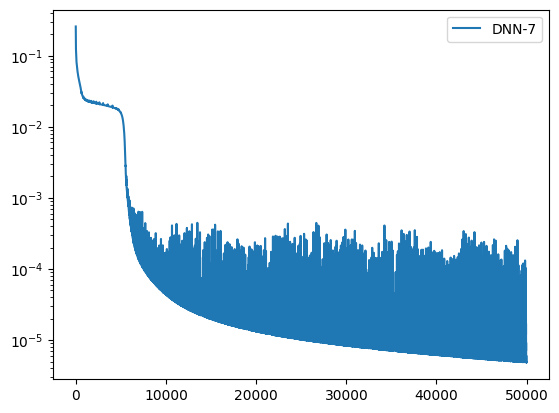

In [10]:
loss = 0
epochs = 50000
opt = tf.keras.optimizers.legacy.Adam(learning_rate=2e-4)
epoch = 0
loss_values = np.array([])
L_values = np.array([])
l_values = np.array([])
lp_values = np.array([])

#
start = time.time()
#
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        T_ = u(x_d, y_d)     

        # Select the loss (mse, msex, ...) for loss on data and add the loss on physics
        L = f(x_c, y_c)
        l = mse(t_d, T_)         
        loss = l + L
        
    g = tape.gradient(loss, model.trainable_weights)
    opt.apply_gradients(zip(g, model.trainable_weights))
    loss_values = np.append(loss_values, loss)   
    
    if epoch % 100 == 0 or epoch == epochs-1:
        print(f"{epoch:5}, {loss.numpy():.8f}")
        lp_values = np.append(lp_values, loss)
        L_values = np.append(L_values, L)
        l_values = np.append(l_values, l)

#
end = time.time()
computation_time = {}
computation_time["pinn"] = end - start
print(f"\ncomputation time: {end-start:.3f}\n")
#
plt.semilogy(loss_values, label=model.name)
plt.legend()



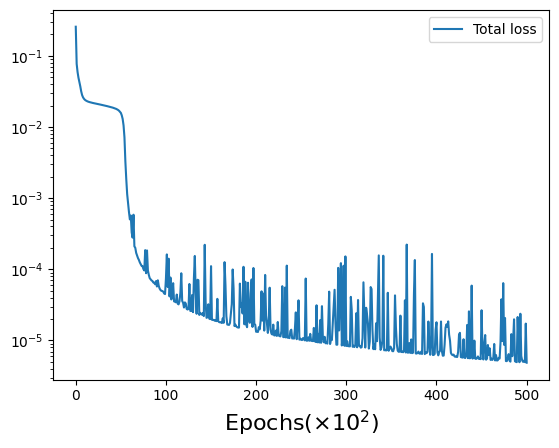

In [11]:
#plt.semilogy(loss_values, label="Total loss")

plt.semilogy(lp_values, label="Total loss")
#plt.semilogy(loss_values, label="Total loss")

plt.xlabel("Epochs" r'($\times 10^2$)',fontsize=16)
plt.legend()


n = 100
l = 1.
r = 2*l/(n+1)
T = np.zeros([n*n, n*n])


/var/folders/55/gkf2h_5j4jjgph1cs8cvzd940000gn/T/ipykernel_8522/201855884.py:46: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/55/gkf2h_5j4jjgph1cs8cvzd940000gn/T/ipykernel_8522/201855884.py:65: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/55/gkf2h_5j4jjgph1cs8cvzd940000gn/T/ipykernel_8522/201855884.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


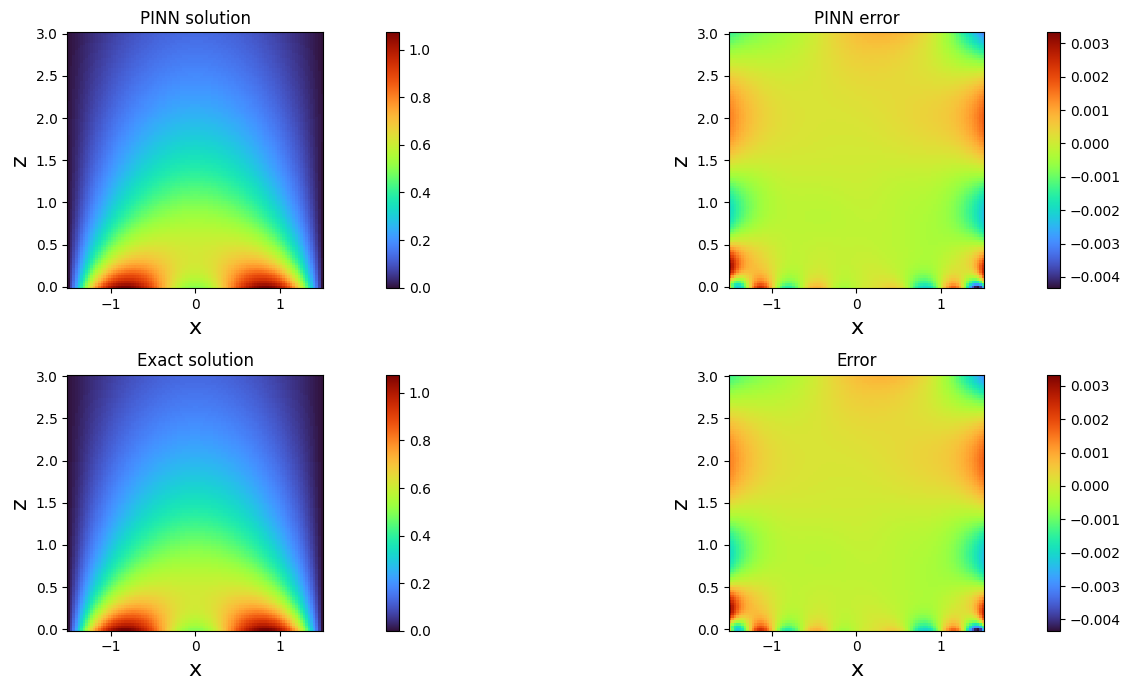

(-1.5, 1.5, 0.0, 3.0)

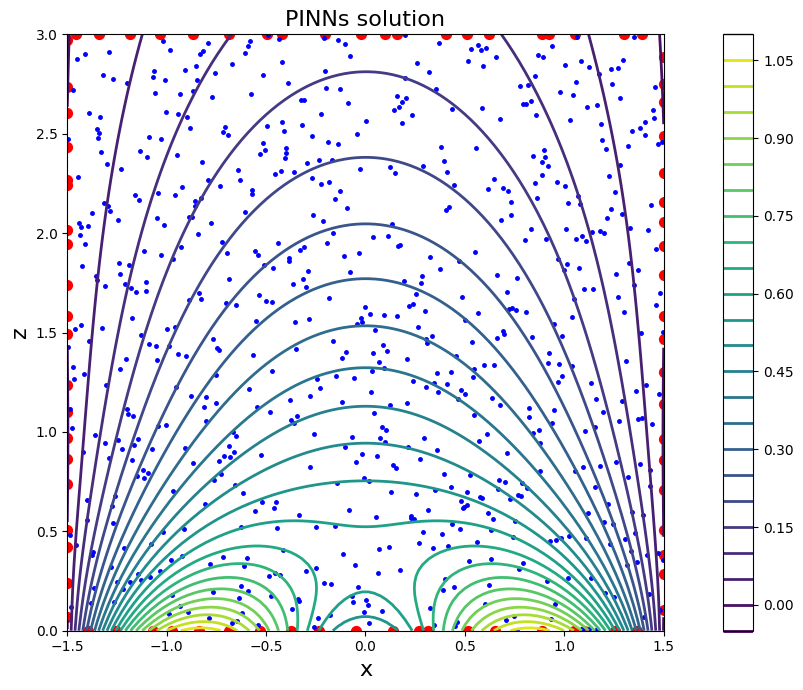

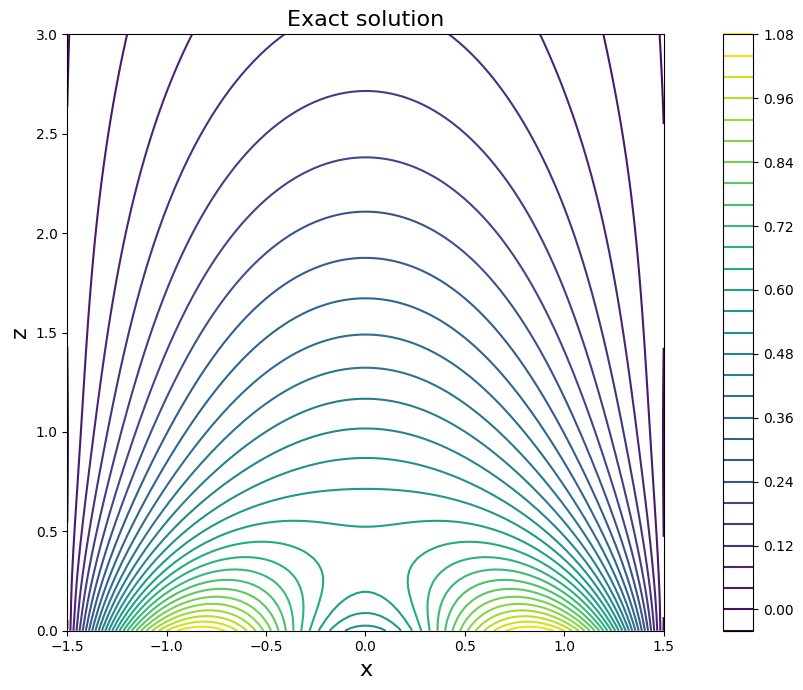

In [12]:
### plotting
#plt.figure("", figsize=(16, 8))
plt.figure("", figsize=(14, 7))
#
X = np.linspace(-lim1, lim1, n)
Y = np.linspace(0., lim2, n)
X0, Y0 = np.meshgrid(X, Y)
X = X0.reshape([n*n, 1])
Y = Y0.reshape([n*n, 1])
X_T = tf.convert_to_tensor(X)
Y_T = tf.convert_to_tensor(Y)

S = u(X_T, Y_T)
S = S.numpy().reshape(n, n)

# True solutions 
TT=tru(X0,Y0)

#
plt.subplot(221)
plt.pcolormesh(X0, Y0, S, cmap="turbo")
plt.colorbar(pad=-0.25)
plt.xlabel("x")
plt.ylabel("z")
plt.xlabel("x",fontsize=16)
plt.ylabel("z",fontsize=16)
plt.title("PINN solution")
plt.tight_layout()
plt.axis("square")
#
x = np.linspace(-lim1, lim1, n)
y = np.linspace(0., lim2, n)
x, y = np.meshgrid(x, y)
#
plt.subplot(222)
plt.pcolormesh(X0, Y0, S - TT, cmap="turbo")
#plt.contour(X0, Y0, S,31)
plt.colorbar(pad=-0.25)
plt.title(r"PINN error")
plt.xlabel("x")
plt.ylabel("z")
plt.xlabel("x",fontsize=16)
plt.ylabel("z",fontsize=16)
plt.xlim(-lim1, lim1)
plt.ylim(0., lim2)
plt.tight_layout()
plt.axis("square")
#plt.savefig("heat01.png")
#
x = np.linspace(-lim1, lim1, n)
y = np.linspace(0, lim2, n)
x, y = np.meshgrid(x, y)

# True solutions 
TT=tru(x,y)

plt.subplot(223)
plt.pcolormesh(X0, Y0, TT, cmap="turbo")
plt.colorbar(pad=-0.25)
plt.xlabel("x")
plt.ylabel("z")
plt.xlabel("x",fontsize=16)
plt.ylabel("z",fontsize=16)
plt.title("Exact solution")
plt.tight_layout()
plt.axis("square")
###

#
plt.subplot(224)
plt.pcolormesh(x, y, -TT + S, cmap="turbo")
plt.colorbar(pad=-0.25)
plt.title("Error")
plt.xlabel("x",fontsize=16)
plt.ylabel("z",fontsize=16)
plt.xlim(-lim1, lim1)
plt.ylim(0, lim2)
plt.tight_layout()
plt.axis("square")
#plt.savefig("heat01.png")
plt.show()


plt.figure("22", figsize=(14, 7))

plt.contour(x, y, S,24,linewidths=2)
plt.colorbar(pad=-0.25)
plt.title(r"PINNs solution",fontsize=16)
plt.scatter(data[:, 0], data[:, 1], marker=".", c="r",s=200, label="BDP")
plt.scatter(colloc[:, 0], colloc[:, 1], s=25, marker=".", c="b", label="CP")
plt.xlabel("x",fontsize=16)
plt.ylabel("z",fontsize=16)
plt.xlim(-lim1, lim1)
plt.ylim(0., lim2)
plt.tight_layout()
plt.axis("square")

#
plt.figure("23", figsize=(14, 7))

plt.contour(x, y, S,27)
plt.colorbar(pad=-0.25)
plt.title(r"Exact solution", fontsize=16)
plt.xlabel("x",fontsize=16)
plt.ylabel("z",fontsize=16)
plt.xlim(-lim1, lim1)
plt.ylim(0., lim2)
plt.tight_layout()
plt.axis("square")


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


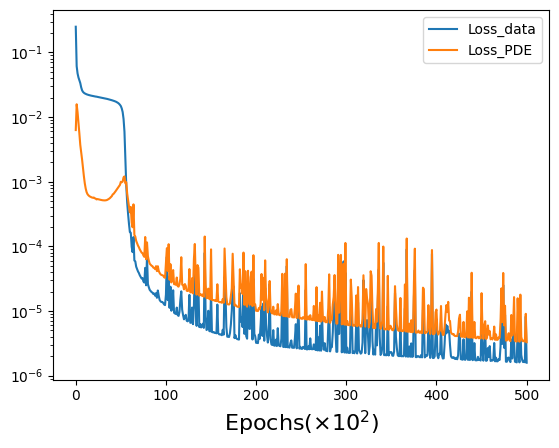

In [13]:
plt.legend()
plt.semilogy(l_values, label='Loss_data')
plt.legend()

plt.semilogy(L_values, label='Loss_PDE')
plt.xlabel("Epochs" r'($\times 10^2$)',fontsize=16)
plt.legend()